In [2]:
# Call excel files called Results_Parameter_Combination.xlsx in the current directory. The code is in Jupyter notebook format.
# This script is intended to be run in a Jupyter notebook environment.
import pandas as pd
import os
# Define the path to the Excel file
file_path = 'Results_Parameter_Combinations.xlsx'
# Check if the file exists
if os.path.exists(file_path):
    # Read the Excel file as a DataFrame
    df = pd.read_excel(file_path)
    # Select columns based on the provided column names
    columns_to_select = [
        'Following_Time', 
        'TTC', 
        'Text_Version', 
        'Traffic_Behind',
        'Passenger_Hurry',
        'Decision'
    ]
    # Select the existing columns
    df = df[columns_to_select]
    # Replace value NaN in Passenger_Hurry column with "not in a hurry"
    df['Passenger_Hurry'] = df['Passenger_Hurry'].fillna('not in a hurry')
    df['Text_Version'] = df['Text_Version'].replace({
    'Unlimited': 'LLM: No-limit',
    'Limited': 'LLM: Few-sentences'})
    df['Traffic_Behind'] = df['Traffic_Behind'].replace({
    'One vehicle behind at 10 m distance': 'Yes',
    'None': 'No'})
    df['Passenger_Hurry'] = df['Passenger_Hurry'].replace({
        'in hurry': 'Yes',
        'not in a hurry': 'No'})
    df['Condition'] = "Behind(" + df['Traffic_Behind'] + ") + Hurry(" + df['Passenger_Hurry'] + ")"
        # Display the DataFrame
    display(df)
else:
    print(f"The file {file_path} does not exist in the current directory.")

,Following_Time,TTC,Text_Version,Traffic_Behind,Passenger_Hurry,Decision,Condition
0,12,1.7,LLM: No-limit,No,No,0,Behind(No) + Hurry(No)
1,12,1.7,LLM: No-limit,No,No,0,Behind(No) + Hurry(No)
2,12,1.7,LLM: No-limit,No,No,0,Behind(No) + Hurry(No)
3,12,1.7,LLM: No-limit,No,No,0,Behind(No) + Hurry(No)
4,12,1.7,LLM: No-limit,No,No,0,Behind(No) + Hurry(No)
...,...,...,...,...,...,...,...
3595,24,8.5,LLM: No-limit,Yes,Yes,1,Behind(Yes) + Hurry(Yes)
3596,24,8.5,LLM: Few-sentences,No,No,0,Behind(No) + Hurry(No)
3597,24,8.5,LLM: Few-sentences,No,Yes,0,Behind(No) + Hurry(Yes)
3598,24,8.5,LLM: Few-sentences,Yes,No,1,Behind(Yes) + Hurry(No)


In [3]:
# Group by the unique combination of columns
grouped_df = df.groupby(["Following_Time", "TTC", "Text_Version", "Traffic_Behind", "Passenger_Hurry"])

# Calculate the average score for Decision == 1
result = grouped_df["Decision"].apply(lambda x: (x.sum() / len(x)) * 100 if len(x) > 0 else 0).reset_index()

result

,Following_Time,TTC,Text_Version,Traffic_Behind,Passenger_Hurry,Decision
0,12,1.7,LLM: Few-sentences,No,No,0.000000
1,12,1.7,LLM: Few-sentences,No,Yes,0.000000
2,12,1.7,LLM: Few-sentences,Yes,No,0.000000
3,12,1.7,LLM: Few-sentences,Yes,Yes,0.000000
4,12,1.7,LLM: No-limit,No,No,0.000000
...,...,...,...,...,...,...
115,24,8.5,LLM: Few-sentences,Yes,Yes,6.666667
116,24,8.5,LLM: No-limit,No,No,60.000000
117,24,8.5,LLM: No-limit,No,Yes,36.666667
118,24,8.5,LLM: No-limit,Yes,No,86.666667


In [4]:
result.to_csv('aggregated_results.csv', index=False)

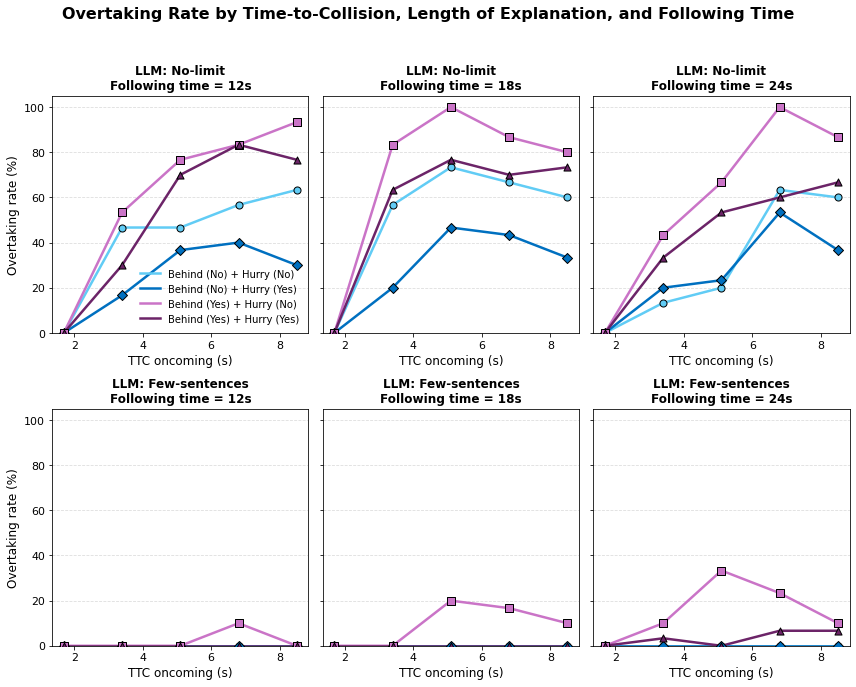

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Step 1: Copy and format condition labels
df = result.copy()
df['Condition'] = "Behind (" + df['Traffic_Behind'] + ") + Hurry (" + df['Passenger_Hurry'] + ")"

# Step 2: Define professional color palette and marker shapes
colors = {
    "Behind (No) + Hurry (No)": "#61CCF5",
    "Behind (Yes) + Hurry (No)": "#CA74C7",
    "Behind (No) + Hurry (Yes)": "#0070C0",
    "Behind (Yes) + Hurry (Yes)": "#6C2468",
}

markers = {
    "Behind (No) + Hurry (No)": "o",
    "Behind (Yes) + Hurry (No)": "s",
    "Behind (No) + Hurry (Yes)": "D",
    "Behind (Yes) + Hurry (Yes)": "^",
}

# Step 3: Smoothing function with deduplication and sorting
def smooth_line(x, y, points=300):
    sorted_indices = np.argsort(x)
    x_sorted = np.array(x)[sorted_indices]
    y_sorted = np.array(y)[sorted_indices]
    x_unique = np.unique(x_sorted)
    y_unique = [np.mean(y_sorted[x_sorted == val]) for val in x_unique]
    if len(x_unique) < 3:
        return x_unique, y_unique
    x_new = np.linspace(min(x_unique), max(x_unique), points)
    spline = make_interp_spline(x_unique, y_unique, k=2)
    y_smooth = spline(x_new)
    return x_new, y_smooth

# Step 4: Create 2x3 plot grid
fig, axs = plt.subplots(2, 3, figsize=(12, 10), sharey=True)
fig.suptitle("Overtaking Rate by Time-to-Collision, Length of Explanation, and Following Time",
             fontsize=16, fontweight='bold')

text_versions = ['LLM: No-limit', 'LLM: Few-sentences']
following_times = [12, 18, 24]

for row, text_version in enumerate(text_versions):
    for col, ft in enumerate(following_times):
        ax = axs[row, col]
        subset = df[(df['Text_Version'] == text_version) & (df['Following_Time'] == ft)]
        
        for condition in df['Condition'].unique():
            cond_data = subset[subset['Condition'] == condition]
            if len(cond_data) < 2:
                continue
            x_vals = cond_data['TTC'].values
            y_vals = cond_data['Decision'].values
            x_smooth, y_smooth = smooth_line(x_vals, y_vals)
            ax.plot(x_vals, y_vals, label=condition,
                    color=colors[condition], linewidth=2.5)
            ax.scatter(x_vals, y_vals, color=colors[condition],
                       marker=markers[condition], edgecolor='black',
                       s=50, zorder=3)

        ax.set_title(f"{text_version}\nFollowing time = {ft}s", fontsize=12, fontweight='semibold')
        ax.set_xlabel("TTC oncoming (s)", fontsize=12)
        if col == 0:
            ax.set_ylabel("Overtaking rate (%)", fontsize=12)

        ax.set_ylim(0, 105)
        ax.tick_params(axis='both', labelsize=11)

        # Gridlines: horizontal only, subtle
        ax.grid(axis='y', linestyle='--', color='#DDDDDD', linewidth=0.8)
        ax.grid(axis='x', visible=False)

        # Legend only in first plot
        if row == 0 and col == 0:
            ax.legend(fontsize=10, frameon=False)

# Step 5: Finalize layout and save/export
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('overtaking_rate_plot_exec_ready.png', dpi=300, bbox_inches='tight')
plt.show()


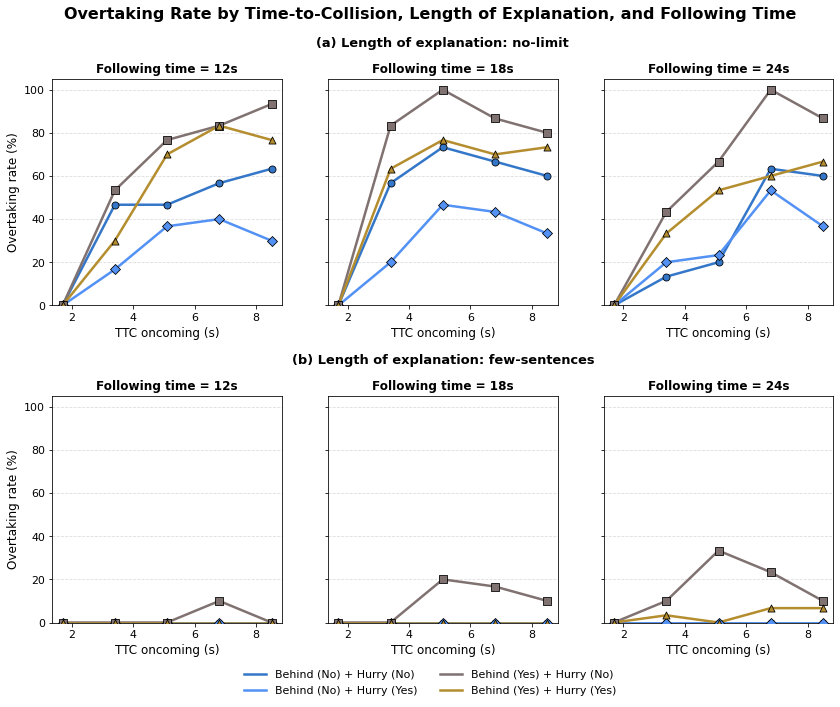

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Copy and format condition labels
df = result.copy()
df["Condition"] = "Behind (" + df["Traffic_Behind"] + ") + Hurry (" + df["Passenger_Hurry"] + ")"

# Step 2: Define color palette and marker shapes
colors = {
    "Behind (No) + Hurry (No)": "#3477C8",
    "Behind (No) + Hurry (Yes)": "#5392F4",
    "Behind (Yes) + Hurry (No)": "#807271",
    "Behind (Yes) + Hurry (Yes)": "#B48D2E",
}

markers = {
    "Behind (No) + Hurry (No)": "o",
    "Behind (No) + Hurry (Yes)": "D",
    "Behind (Yes) + Hurry (No)": "s",
    "Behind (Yes) + Hurry (Yes)": "^",
}

# Fixed order for consistent legend + readability
condition_order = [
    "Behind (No) + Hurry (No)",
    "Behind (No) + Hurry (Yes)",
    "Behind (Yes) + Hurry (No)",
    "Behind (Yes) + Hurry (Yes)",
]

# Step 3: Create 2x3 plot grid
fig, axs = plt.subplots(2, 3, figsize=(14, 10), sharey=True)

fig.subplots_adjust(hspace=0.4)  # <-- ADD THIS LINE (more vertical distance between row 1 and row 2)

fig.suptitle(
    "Overtaking Rate by Time-to-Collision, Length of Explanation, and Following Time",
    fontsize=16, fontweight="bold"
)


text_versions = ["LLM: No-limit", "LLM: Few-sentences"]
following_times = [12, 18, 24]

# Collect handles once for a shared legend
legend_handles = {}

for row, text_version in enumerate(text_versions):
    for col, ft in enumerate(following_times):
        ax = axs[row, col]
        subset = df[(df["Text_Version"] == text_version) & (df["Following_Time"] == ft)]

        for condition in condition_order:
            cond_data = subset[subset["Condition"] == condition]
            if len(cond_data) < 2:
                continue

            # Sort by TTC so line segments connect in the right order
            cond_data = cond_data.sort_values("TTC")
            x_vals = cond_data["TTC"].values
            y_vals = cond_data["Decision"].values

            # Straight segments (no smoothing)
            line, = ax.plot(
                x_vals, y_vals,
                color=colors[condition],
                linewidth=2.5,
                label=condition
            )

            ax.scatter(
                x_vals, y_vals,
                color=colors[condition],
                marker=markers[condition],
                edgecolors="black",
                linewidths=0.8,
                s=50,
                zorder=3
            )

            if condition not in legend_handles:
                legend_handles[condition] = line

        ax.set_title(f"Following time = {ft}s", fontsize=12, fontweight="semibold")
        ax.set_xlabel("TTC oncoming (s)", fontsize=12)
        if col == 0:
            ax.set_ylabel("Overtaking rate (%)", fontsize=12)

        ax.set_ylim(0, 105)
        ax.tick_params(axis="both", labelsize=11)

        # Gridlines: horizontal only, subtle
        ax.grid(axis="y", linestyle="--", color="#DDDDDD", linewidth=0.8)
        ax.grid(axis="x", visible=False)

# Step 4: Shared legend AFTER the second row (bottom center)
handles = [legend_handles[c] for c in condition_order if c in legend_handles]
labels = [c for c in condition_order if c in legend_handles]

fig.legend(
    handles, labels,
    loc="lower center",
    ncol=2,            # set to 4 if you want one row
    frameon=False,
    fontsize=11,
    bbox_to_anchor=(0.5, 0.01)
)

# --- Add row labels (a) and (b) for explanation-length conditions ---
# Make sure layout is computed so positions are correct
fig.canvas.draw()

# Get left and right edges of the subplot grid
left = axs[0, 0].get_position().x0
right = axs[0, 2].get_position().x1
x_center = 0.5 * (left + right)

# Y positions for the two rows
top_row_y = axs[0, 0].get_position().y1
bottom_row_y = axs[1, 0].get_position().y1

# Centered row labels
fig.text(
    x_center, top_row_y + 0.04,
    "(a) Length of explanation: no-limit",
    ha="center", va="bottom",
    fontsize=13, fontweight="bold"
)

fig.text(
    x_center, bottom_row_y + 0.04,
    "(b) Length of explanation: few-sentences",
    ha="center", va="bottom",
    fontsize=13, fontweight="bold"
)


# Step 5: Layout and save
# plt.tight_layout(rect=[0, 0.08, 1, 0.95])  # leave room at bottom for legend
plt.savefig("overtaking_rate_plot_exec_ready.png", dpi=300, bbox_inches="tight")
plt.show()


Test if prompt is changed from "Vehicle passenger: a passenger in a hurry" to "AV passenger is in a hurry". Why? Maybe LLM will think of oncoming vehicle passenger in a hurry.

In [26]:
# Call excel files called Results_Parameter_Combination.xlsx in the current directory. The code is in Jupyter notebook format.
# This script is intended to be run in a Jupyter notebook environment.
import pandas as pd
import os
# Define the path to the Excel file
file_path = 'Results_Parameter_Combinations_Only_Passenger_Hurry.xlsx'
# Check if the file exists
if os.path.exists(file_path):
    # Read the Excel file as a DataFrame
    df = pd.read_excel(file_path)
    # Select columns based on the provided column names
    columns_to_select = [
        'Following_Time', 
        'TTC', 
        'Text_Version', 
        'Traffic_Behind',
        'Passenger_Hurry',
        'Decision'
    ]
    # Select the existing columns
    df = df[columns_to_select]
    # Replace value NaN in Passenger_Hurry column with "not in a hurry"
    df['Passenger_Hurry'] = df['Passenger_Hurry'].fillna('not in a hurry')
    df['Text_Version'] = df['Text_Version'].replace({
    'Unlimited': 'LLM: Long output',
    'Limited': 'LLM: Short output'})
    df['Traffic_Behind'] = df['Traffic_Behind'].replace({
    'One vehicle behind at 10 m distance': 'Yes',
    'None': 'No'})
    df['Passenger_Hurry'] = df['Passenger_Hurry'].replace({
        'in hurry': 'Yes',
        'not in a hurry': 'No'})
    df['Condition'] = "Behind(" + df['Traffic_Behind'] + ") + Hurry(" + df['Passenger_Hurry'] + ")"
        # Display the DataFrame
    display(df)
else:
    print(f"The file {file_path} does not exist in the current directory.")

,Following_Time,TTC,Text_Version,Traffic_Behind,Passenger_Hurry,Decision,Condition
0,12,1.7,LLM: Long output,No,Yes,0,Behind(No) + Hurry(Yes)
1,12,1.7,LLM: Long output,No,Yes,0,Behind(No) + Hurry(Yes)
2,12,1.7,LLM: Long output,Yes,Yes,0,Behind(Yes) + Hurry(Yes)
3,12,1.7,LLM: Long output,Yes,Yes,0,Behind(Yes) + Hurry(Yes)
4,12,1.7,LLM: Short output,No,Yes,0,Behind(No) + Hurry(Yes)
...,...,...,...,...,...,...,...
115,24,8.5,LLM: Long output,Yes,Yes,1,Behind(Yes) + Hurry(Yes)
116,24,8.5,LLM: Short output,No,Yes,0,Behind(No) + Hurry(Yes)
117,24,8.5,LLM: Short output,No,Yes,0,Behind(No) + Hurry(Yes)
118,24,8.5,LLM: Short output,Yes,Yes,0,Behind(Yes) + Hurry(Yes)


In [27]:
# Group by the unique combination of columns
grouped_df = df.groupby(["Following_Time", "TTC", "Text_Version", "Traffic_Behind", "Passenger_Hurry"])

# Calculate the average score for Decision == 1
result = grouped_df["Decision"].apply(lambda x: (x.sum() / len(x)) * 100 if len(x) > 0 else 0).reset_index()

result

,Following_Time,TTC,Text_Version,Traffic_Behind,Passenger_Hurry,Decision
0,12,1.7,LLM: Long output,No,Yes,0.0
1,12,1.7,LLM: Long output,Yes,Yes,0.0
2,12,1.7,LLM: Short output,No,Yes,0.0
3,12,1.7,LLM: Short output,Yes,Yes,0.0
4,12,3.4,LLM: Long output,No,Yes,0.0
5,12,3.4,LLM: Long output,Yes,Yes,0.0
6,12,3.4,LLM: Short output,No,Yes,0.0
7,12,3.4,LLM: Short output,Yes,Yes,0.0
8,12,5.1,LLM: Long output,No,Yes,0.0
9,12,5.1,LLM: Long output,Yes,Yes,0.0


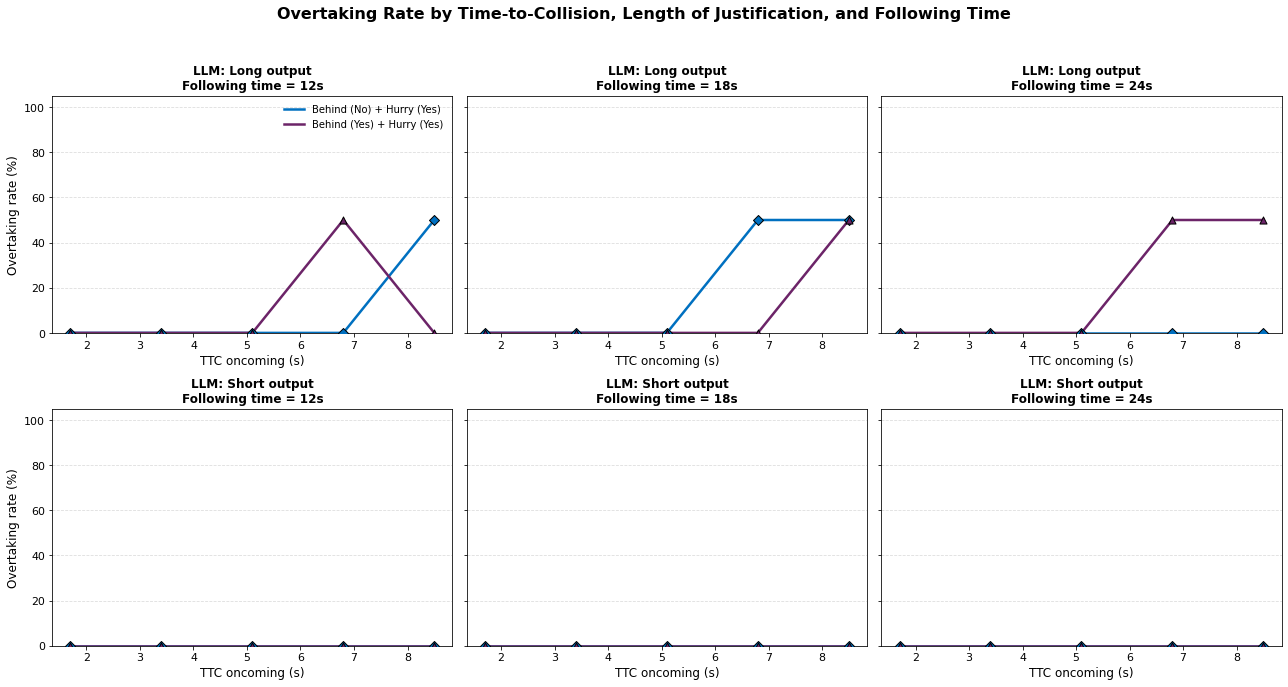

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Step 1: Copy and format condition labels
df = result.copy()
df['Condition'] = "Behind (" + df['Traffic_Behind'] + ") + Hurry (" + df['Passenger_Hurry'] + ")"

# Step 2: Define professional color palette and marker shapes
colors = {
    "Behind (No) + Hurry (No)": "#61CCF5",
    "Behind (Yes) + Hurry (No)": "#CA74C7",
    "Behind (No) + Hurry (Yes)": "#0070C0",
    "Behind (Yes) + Hurry (Yes)": "#6C2468",
}

markers = {
    "Behind (No) + Hurry (No)": "o",
    "Behind (Yes) + Hurry (No)": "s",
    "Behind (No) + Hurry (Yes)": "D",
    "Behind (Yes) + Hurry (Yes)": "^",
}

# Step 3: Smoothing function with deduplication and sorting
def smooth_line(x, y, points=300):
    sorted_indices = np.argsort(x)
    x_sorted = np.array(x)[sorted_indices]
    y_sorted = np.array(y)[sorted_indices]
    x_unique = np.unique(x_sorted)
    y_unique = [np.mean(y_sorted[x_sorted == val]) for val in x_unique]
    if len(x_unique) < 3:
        return x_unique, y_unique
    x_new = np.linspace(min(x_unique), max(x_unique), points)
    spline = make_interp_spline(x_unique, y_unique, k=2)
    y_smooth = spline(x_new)
    return x_new, y_smooth

# Step 4: Create 2x3 plot grid
fig, axs = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
fig.suptitle("Overtaking Rate by Time-to-Collision, Length of Justification, and Following Time",
             fontsize=16, fontweight='bold')

text_versions = ['LLM: Long output', 'LLM: Short output']
following_times = [12, 18, 24]

for row, text_version in enumerate(text_versions):
    for col, ft in enumerate(following_times):
        ax = axs[row, col]
        subset = df[(df['Text_Version'] == text_version) & (df['Following_Time'] == ft)]
        
        for condition in df['Condition'].unique():
            cond_data = subset[subset['Condition'] == condition]
            if len(cond_data) < 2:
                continue
            x_vals = cond_data['TTC'].values
            y_vals = cond_data['Decision'].values
            x_smooth, y_smooth = smooth_line(x_vals, y_vals)
            ax.plot(x_vals, y_vals, label=condition,
                    color=colors[condition], linewidth=2.5)
            ax.scatter(x_vals, y_vals, color=colors[condition],
                       marker=markers[condition], edgecolor='black',
                       s=50, zorder=3)

        ax.set_title(f"{text_version}\nFollowing time = {ft}s", fontsize=12, fontweight='semibold')
        ax.set_xlabel("TTC oncoming (s)", fontsize=12)
        if col == 0:
            ax.set_ylabel("Overtaking rate (%)", fontsize=12)

        ax.set_ylim(0, 105)
        ax.tick_params(axis='both', labelsize=11)

        # Gridlines: horizontal only, subtle
        ax.grid(axis='y', linestyle='--', color='#DDDDDD', linewidth=0.8)
        ax.grid(axis='x', visible=False)

        # Legend only in first plot
        if row == 0 and col == 0:
            ax.legend(fontsize=10, frameon=False)

# Step 5: Finalize layout and save/export
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('overtaking_rate_plot_exec_ready.png', dpi=300, bbox_inches='tight')
plt.show()
